In [1]:
# Global imports
import numpy as np
from time import time
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data
from scipy.stats import wasserstein_distance

# # Additional Code for Colab. Comment out if not using Colab.
# from google.colab import drive
# drive.mount('/content/drive')
#
# import sys
# sys.path.append('/content/drive/MyDrive/School/Fall 2022/COMP 5340')

# Imports from support classes
from SupportClasses import SupportClass as sc
from SupportClasses import DCGAN as dg
from SupportClasses import WGAN as wg
from SupportClasses import VAE as vae

Mounted at /content/drive


In [2]:
# Code cell for preparing data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mnist_train_set, mnist_test_set = sc.download_mnist()
cifar_train_set, cifar_test_set = sc.download_cifar10()

mnist_train_loader, mnist_test_loader = sc.create_data_loaders(mnist_train_set, mnist_test_set)
cifar_train_loader, cifar_test_loader = sc.create_data_loaders(cifar_train_set, cifar_test_set)

# Other global values

cuda:0


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Generative Adversarial Network (GAN)

In [7]:
# Code cell for preparing the DCGAN model
opt = dg.Opt()
print(opt.latent_dim)
img_shape = (opt.channels, opt.img_size, opt.img_size)

# Define the loss, generator and discriminator
bce_loss = torch.nn.BCELoss()
dcgan_generator = dg.Generator(img_shape=img_shape, opt=opt)
dcgan_discriminator = dg.Discriminator(img_shape=img_shape)

print(dcgan_generator)
print(dcgan_discriminator)

# Send the models to the device we're working with
dcgan_generator.to(device=device)
dcgan_discriminator.to(device=device)
bce_loss.to(device=device)

# Define the optimizers for the generator and discriminator.
dcgan_generator_optimizer = torch.optim.Adam(dcgan_generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
dcgan_discriminator_optimizer = torch.optim.Adam(dcgan_discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

200
Generator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=T

In [8]:
# Code cell for training the DCGAN model
dcgan_saved_imgs = []
per_epoch_jsd = []
for epoch in range(opt.n_epochs):
    start_time = time()
    dist_pd, dist_pg = None, None
    for i, (imgs, _) in enumerate(mnist_train_loader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))

        # Train the generator
        dcgan_generator_optimizer.zero_grad()

        # Get noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = dcgan_generator(z)

        # Calculate the generator's loss. Its ability to fool the generator
        dcgan_generator_loss = bce_loss(dcgan_discriminator(gen_imgs), real)
        dcgan_generator_loss.backward()
        dcgan_generator_optimizer.step()

        # Train the discriminator
        dcgan_discriminator.zero_grad()

        # Get the probability dist for p_d and p_g
        p_d = dcgan_discriminator(real_imgs)
        p_g = dcgan_discriminator(gen_imgs.detach())

        # Measure the discriminator's loss. Its ability to determine real from fake.
        real_loss = bce_loss(p_d, real)
        fake_loss = bce_loss(p_g, fake)

        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        dcgan_discriminator_optimizer.step()
        batches_done = epoch * len(mnist_train_loader) + i

        # Append the p_d and p_g outputs
        if dist_pd is None:
            dist_pd, dist_pg = p_d, p_g
        else:
            dist_pd = torch.cat((dist_pd, p_d), 0)
            dist_pg = torch.cat((dist_pg, p_g), 0)
    end_time = time()

    # Here we will calculate the JSD for the epoch
    jsd = dg.calculate_jsd(dist_pd, dist_pg)
    per_epoch_jsd.append(abs(jsd.item()))

    # Get the time to perform this epoch
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Jensen Shannon Divergence: {abs(jsd.item()):.3f} | Epoch time (GAN Training): {epoch_mins}m {epoch_secs}s')
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    dcgan_saved_imgs.append(img)

KeyboardInterrupt: ignored

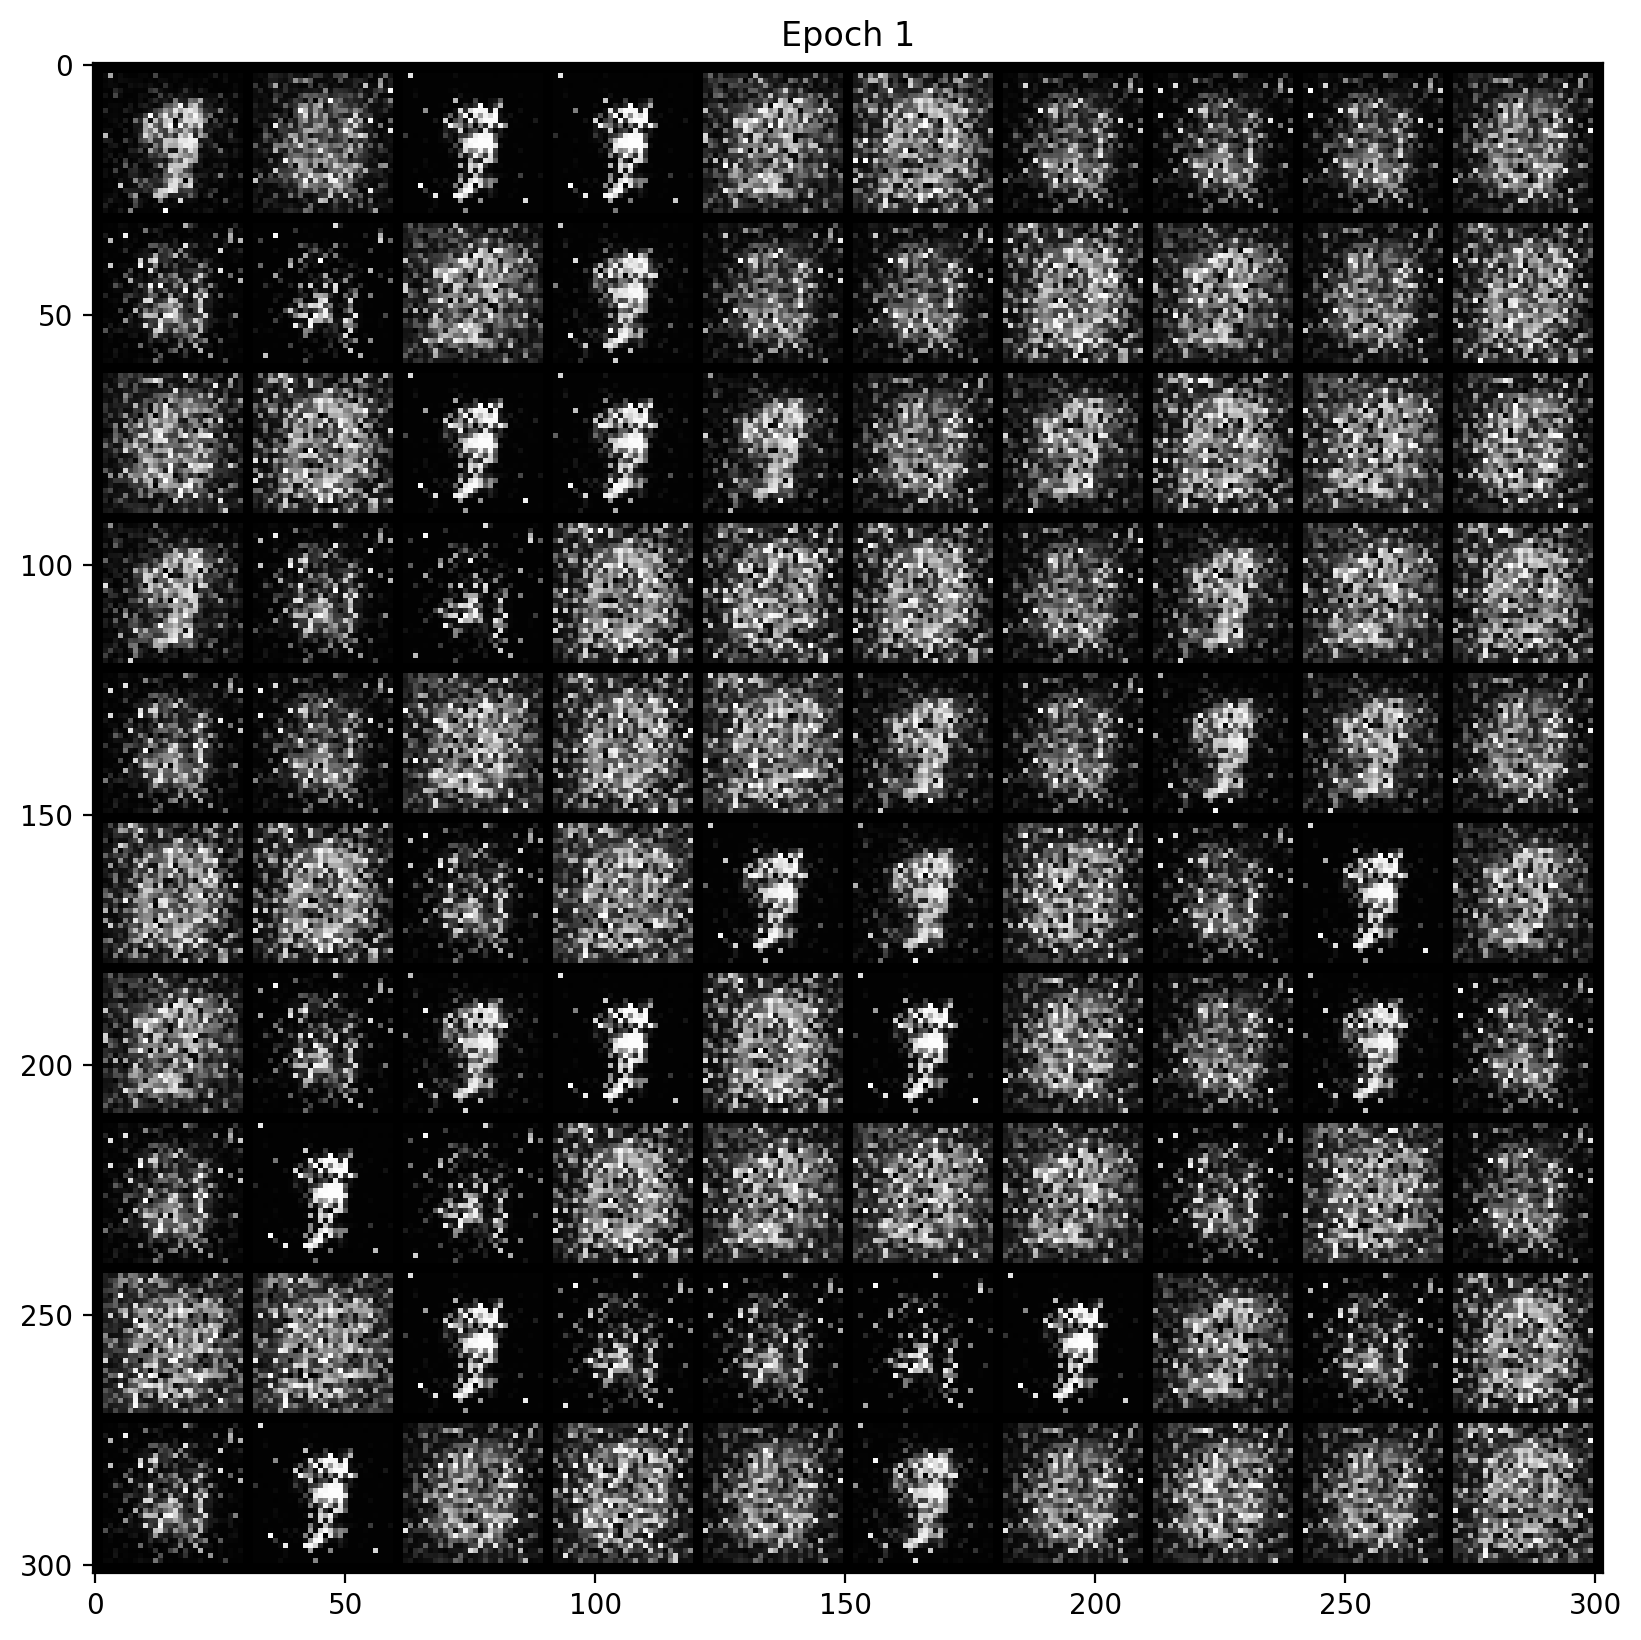

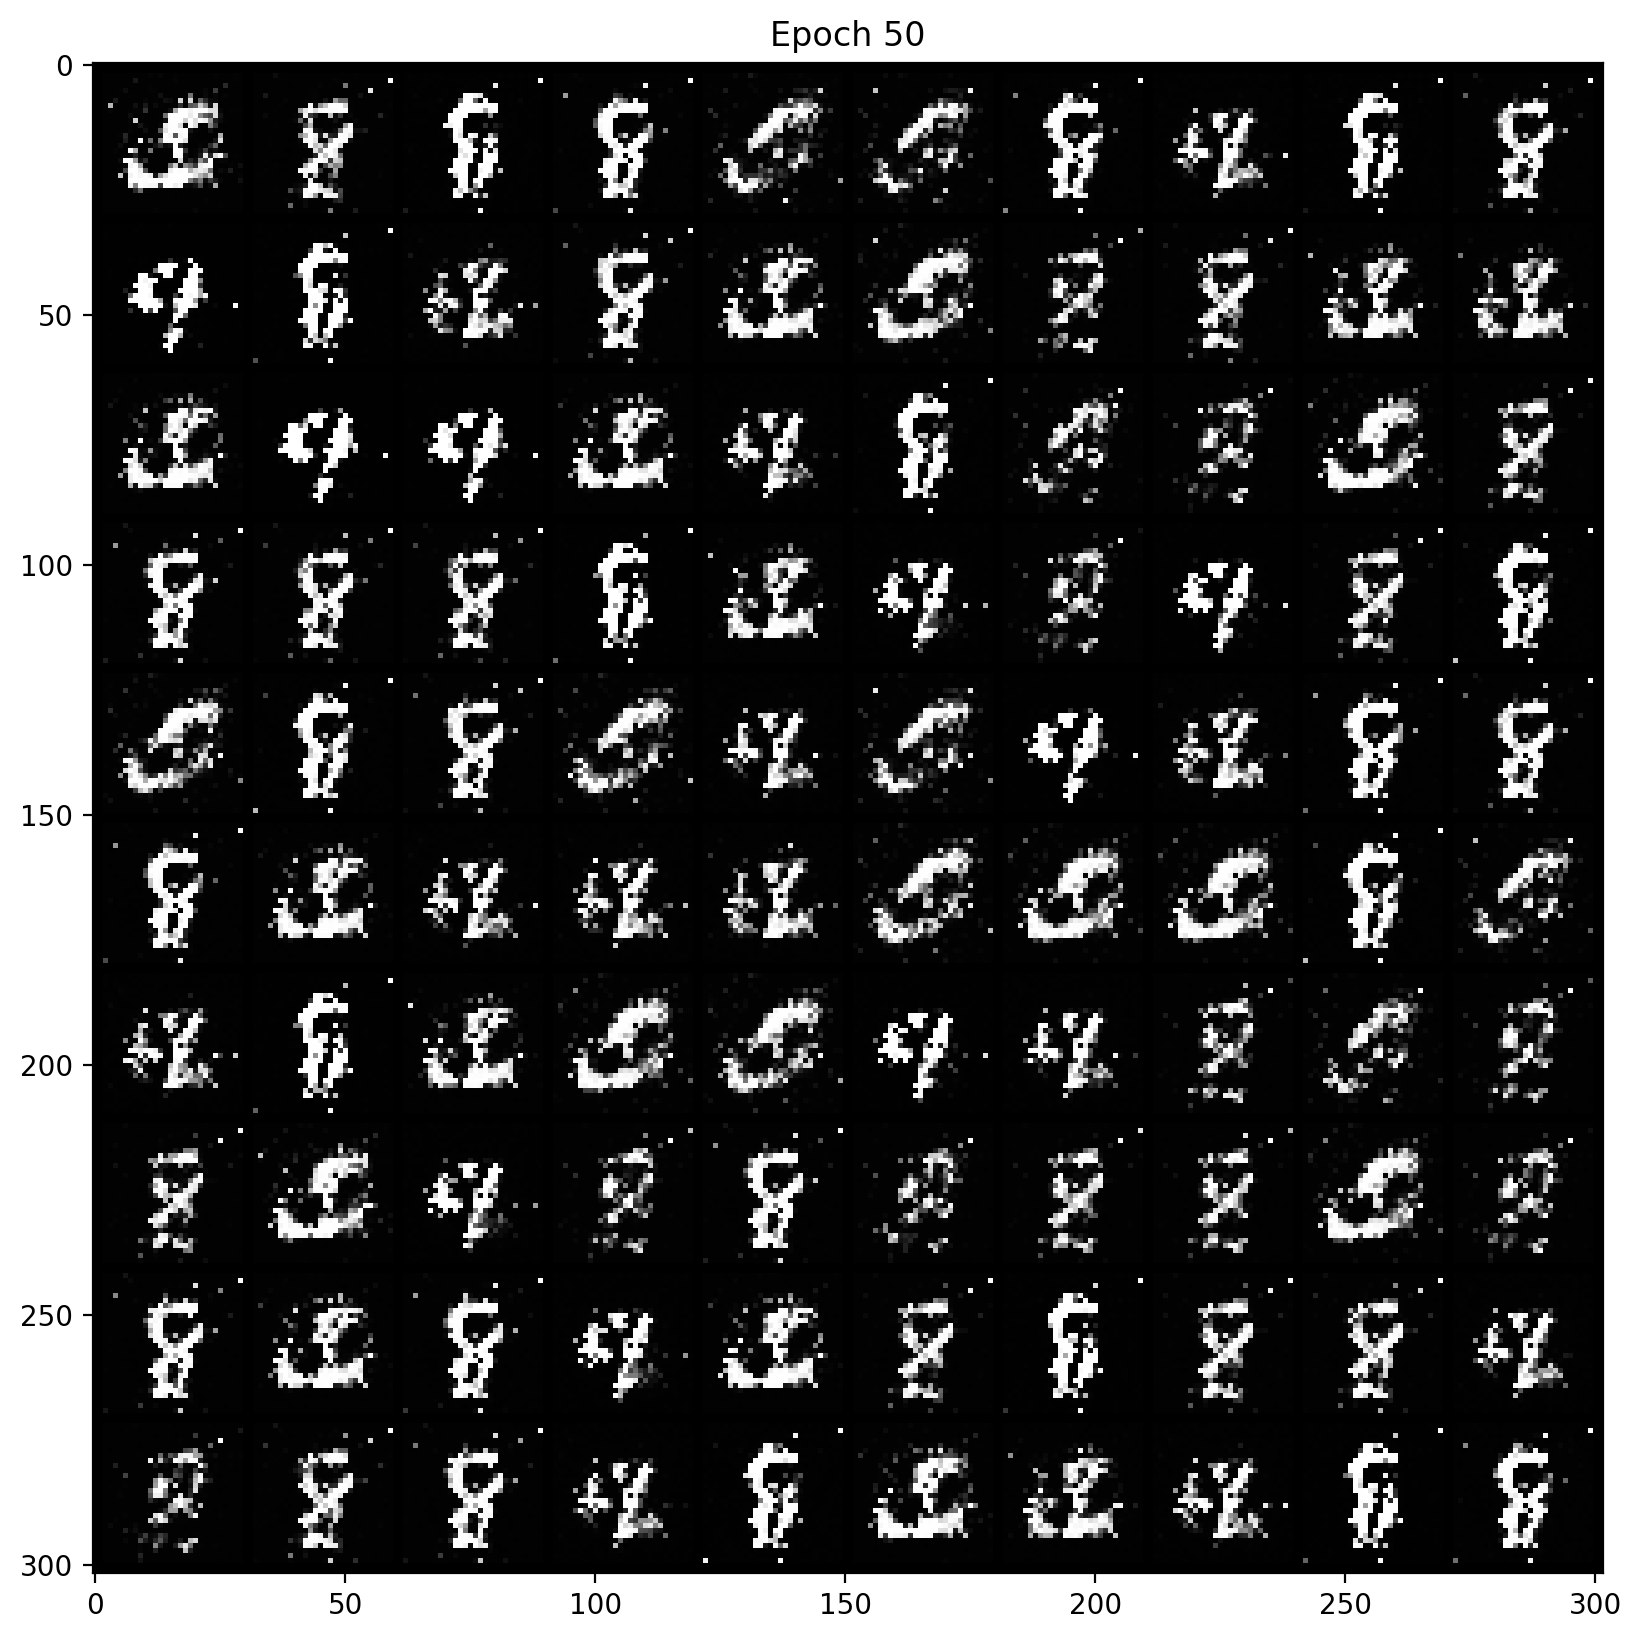

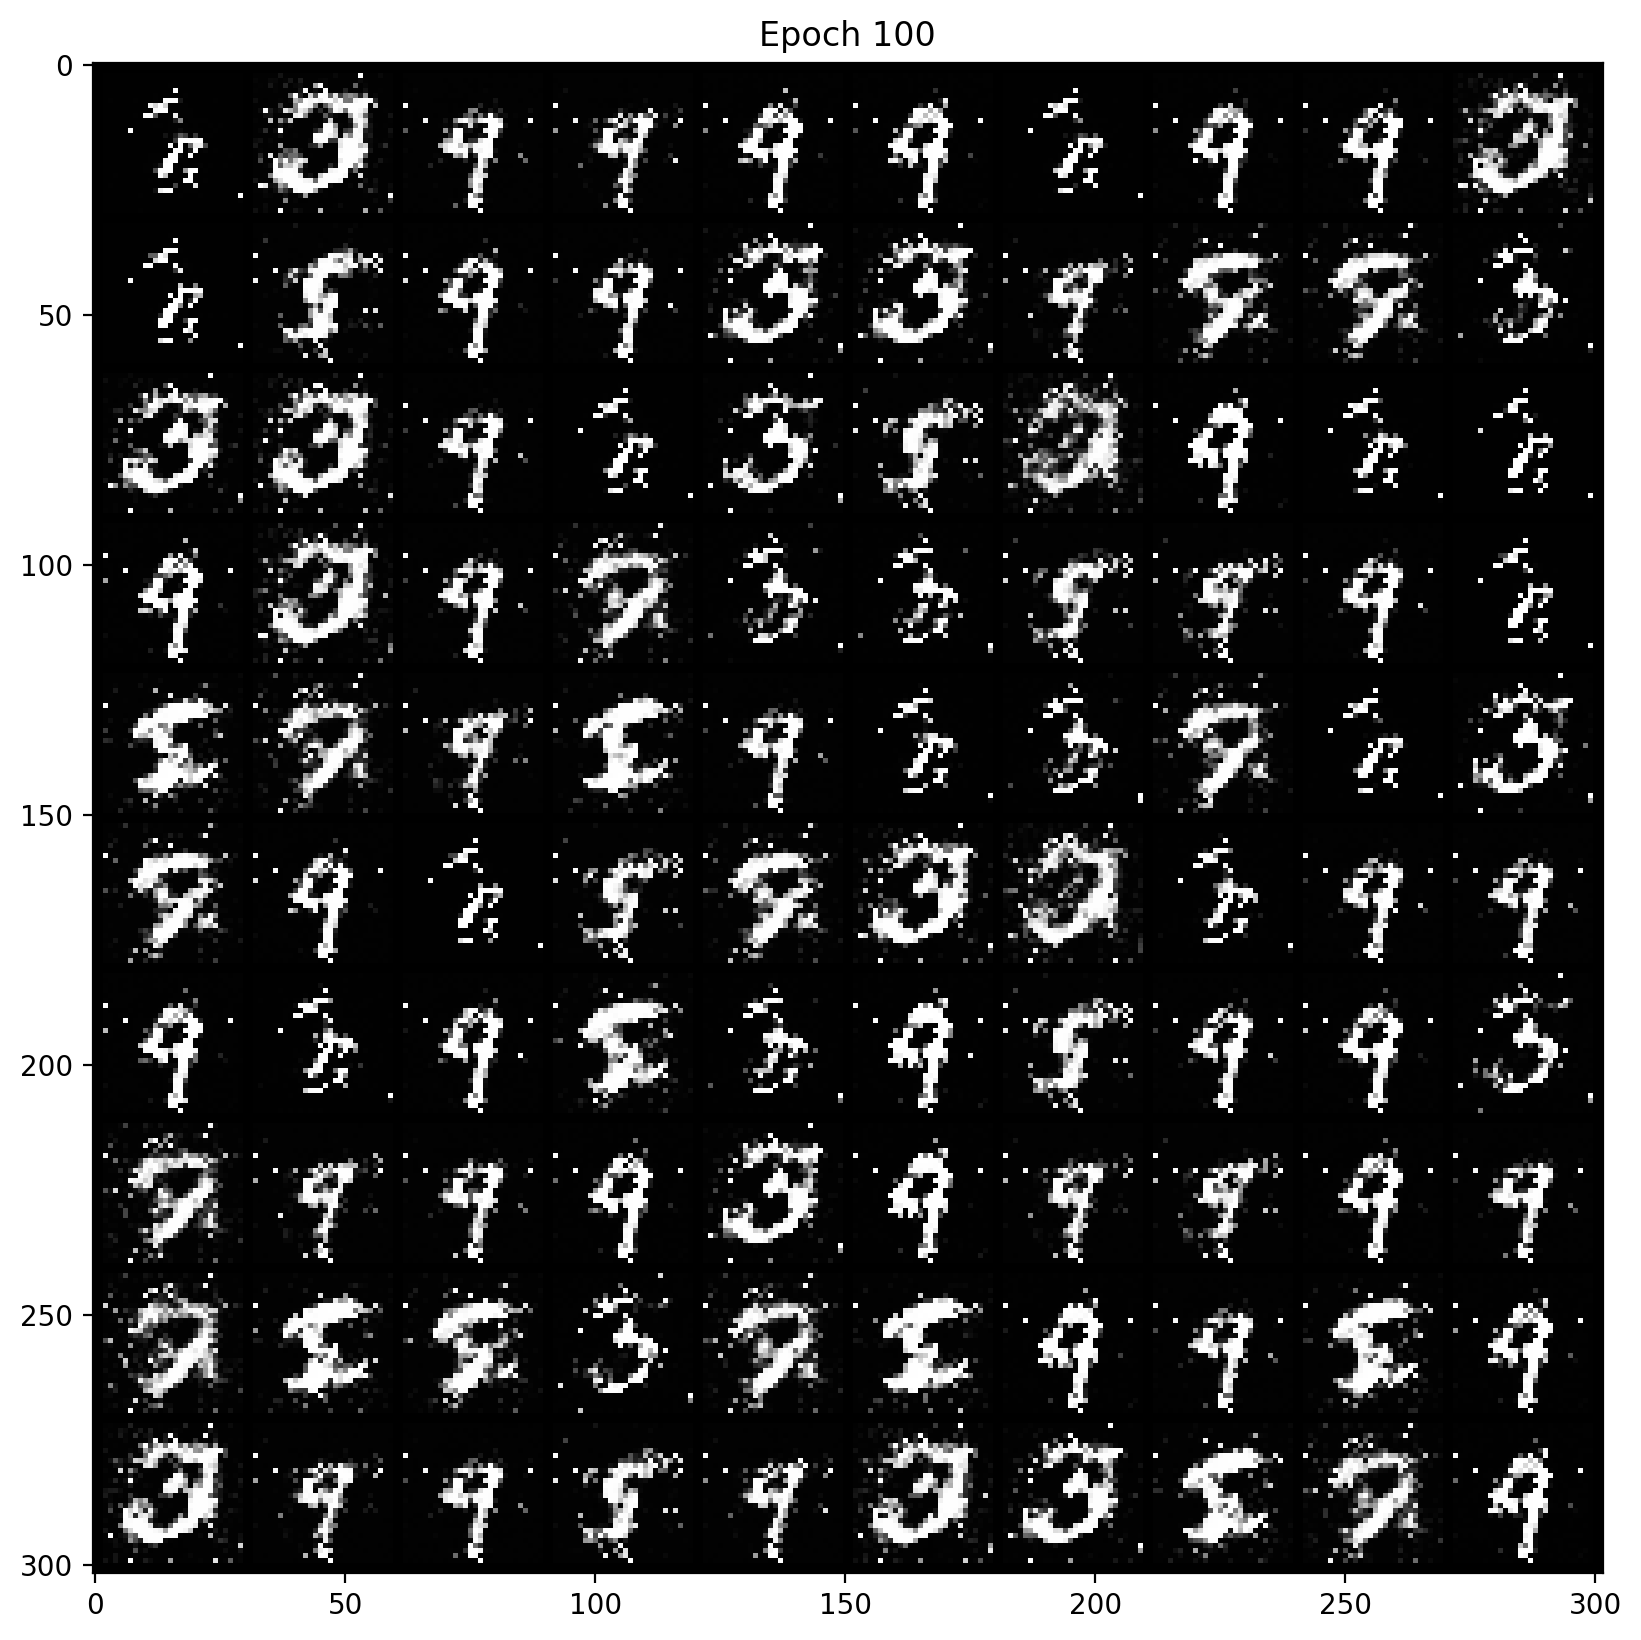

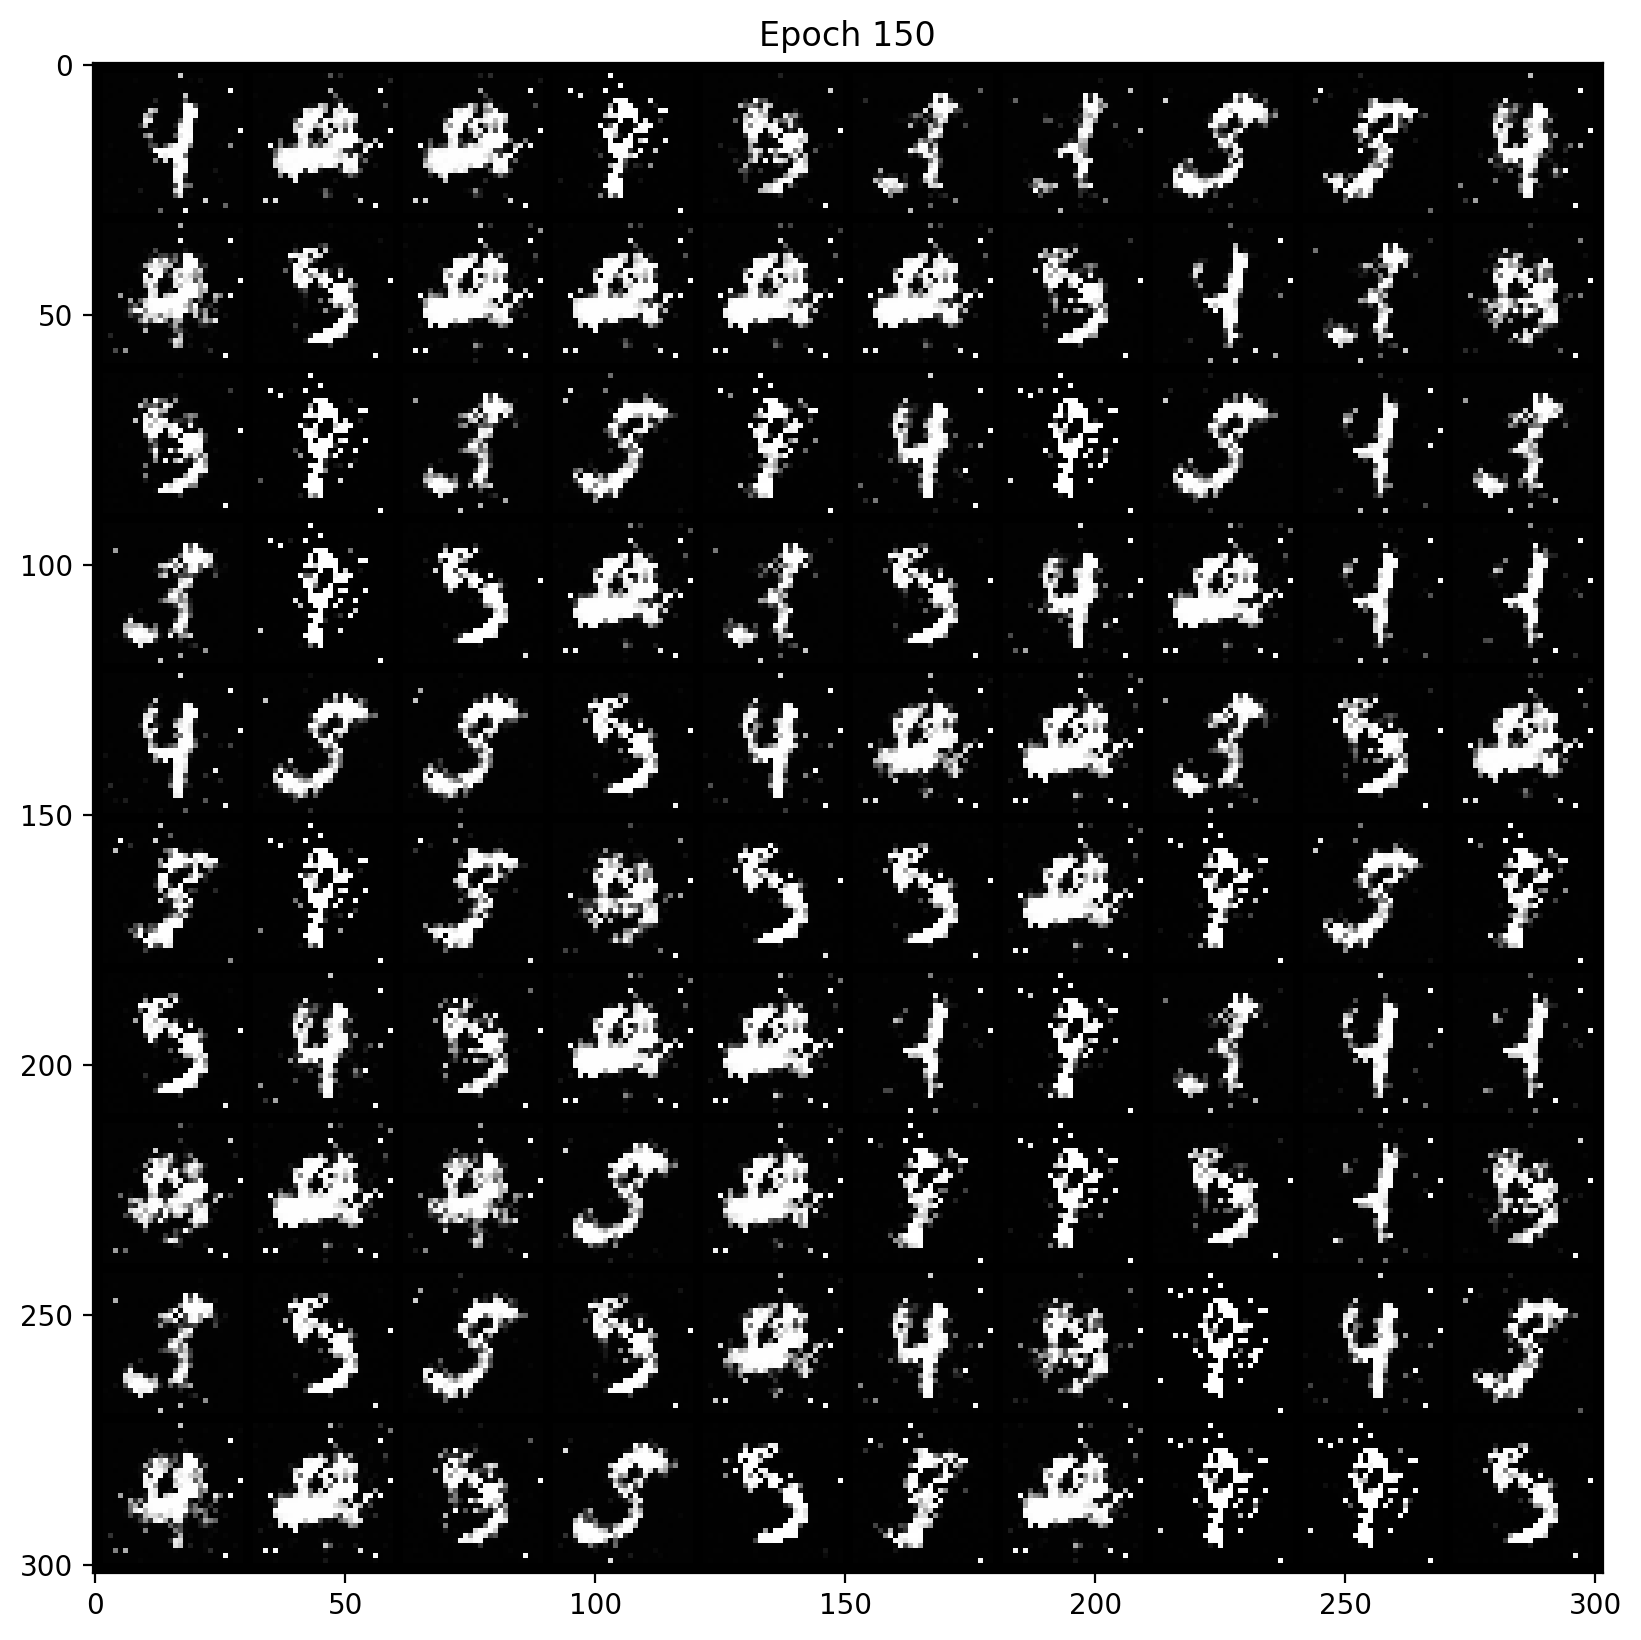

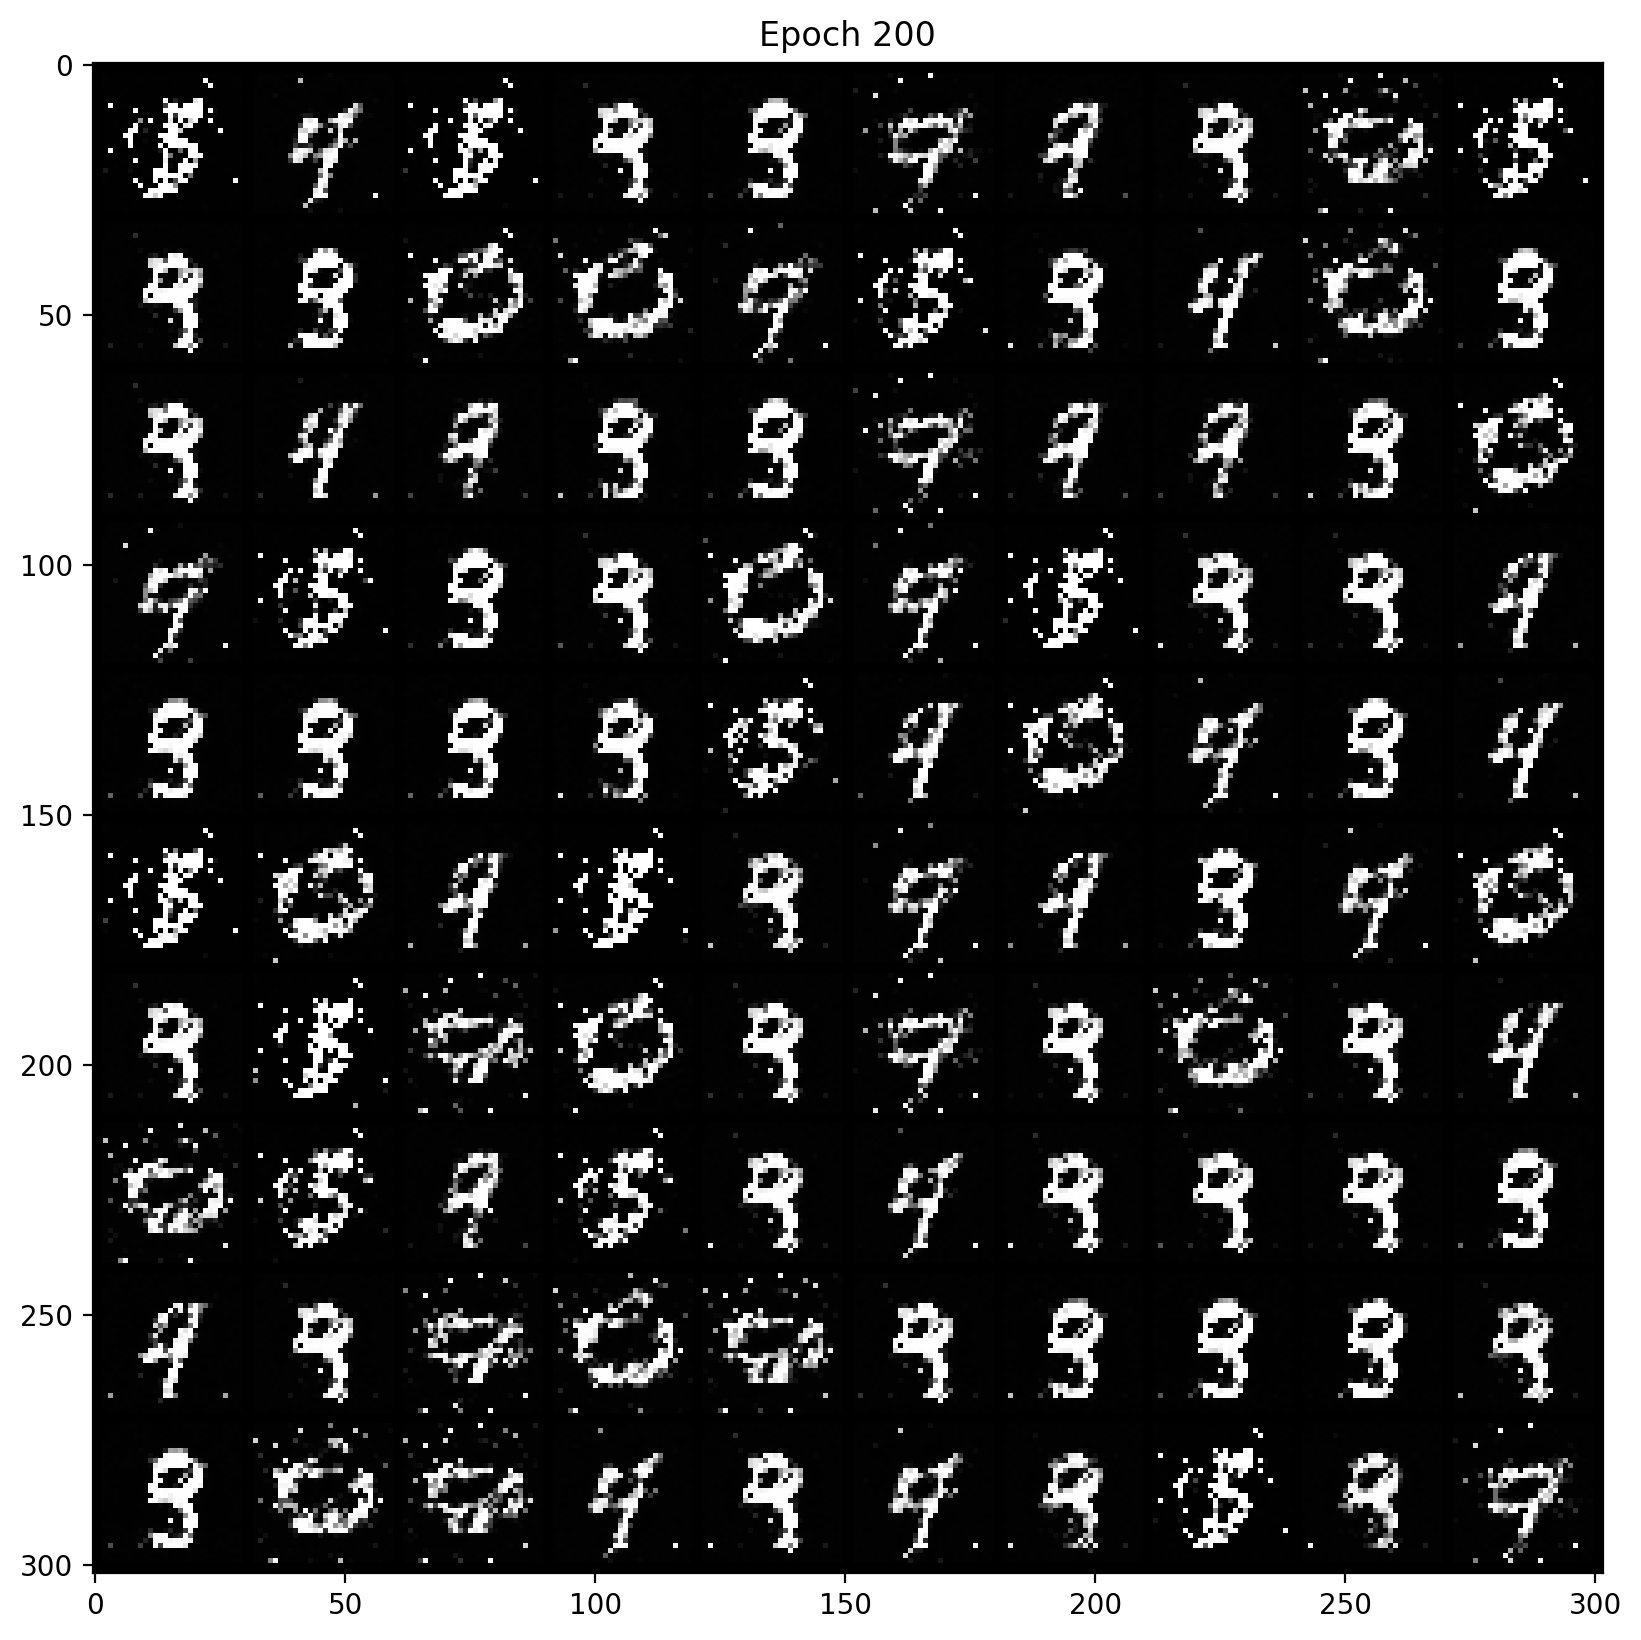

In [9]:
img_indexes = [0, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.title(f'Epoch {i+1}')
    plt.imshow(dcgan_saved_imgs[i], interpolation='nearest')
    plt.savefig(f'/content/drive/MyDrive/School/Fall 2022/COMP 5340/Images/Epoch_{i+1}')

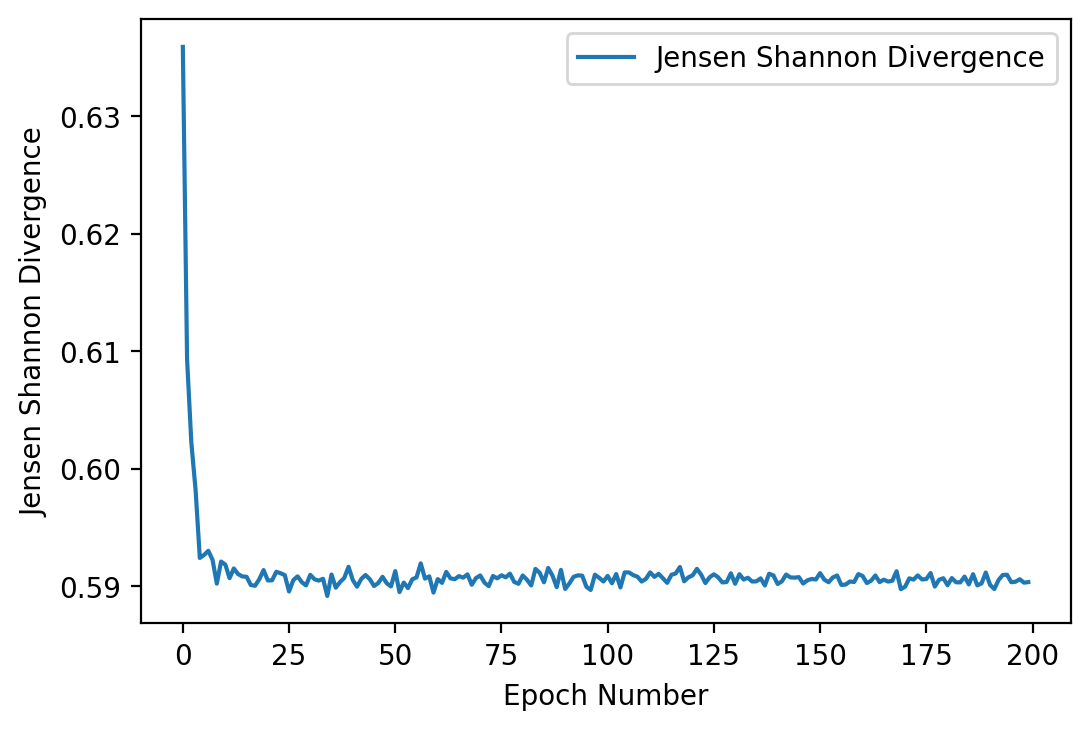

<Figure size 1200x800 with 0 Axes>

In [11]:
# Plot Jensen Shannon Divergence
plt.plot([i for i in range(opt.n_epochs)], per_epoch_jsd, label='Jensen Shannon Divergence')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Jensen Shannon Divergence")

# Show the plot
plt.show()
plt.savefig(f'/content/drive/MyDrive/School/Fall 2022/COMP 5340/Images/JSD')

# Wasserstein GAN (WGAN)

In [14]:
# Code cell for preparing the WGAN
opt = wg.Opt()
print(opt.latent_dim)
img_shape = (opt.channels, opt.img_size, opt.img_size)

# Define the generator and discriminator
wgan_generator = wg.Generator(img_shape=img_shape, opt=opt)
wgan_discriminator = wg.Discriminator(img_shape=img_shape)

print(wgan_generator)
print(wgan_discriminator)

# Send the models to the device we're working with
wgan_generator.to(device=device)
wgan_discriminator.to(device=device)


# Define the optimizers for the generator and discriminator.
wgan_generator_optimizer = torch.optim.RMSprop(wgan_generator.parameters(), lr=opt.lr)
wgan_discriminator_optimizer = torch.optim.RMSprop(wgan_discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

200
Generator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=3072, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace

In [5]:
# Code cell for training the WGAN model
per_epoch_emd = []
wgan_saved_imgs = []
for epoch in range(opt.n_epochs):
    start_time = time()
    dist_pd, dist_pg = None, None
    for i, (imgs, _) in enumerate(mnist_train_loader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        wgan_discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        fake_imgs = wgan_generator(z).detach()
        # Adversarial loss
        p_g = wgan_discriminator(fake_imgs)
        p_d = wgan_discriminator(real_imgs)
        discriminator_loss = torch.mean(p_g) - torch.mean(p_d)
        discriminator_loss.backward()
        wgan_discriminator_optimizer.step()
        # clip weights of discriminator
        for p in wgan_discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # train Generator
            wgan_generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = wgan_generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(wgan_discriminator(critics_fake_imgs))
            generator_loss.backward()
            wgan_generator_optimizer.step()
        # Append the p_d and p_g outputs
        if dist_pd is None:
            dist_pd, dist_pg = p_d, p_g
        else:
            dist_pd = torch.cat((dist_pd, p_d), 0)
            dist_pg = torch.cat((dist_pg, p_g), 0)
    end_time = time()

    # Get the Wasserstein Distance (Earth Mover's Distance)
    emd = wasserstein_distance(dist_pd[:, 0].cpu().detach().numpy(), dist_pg[:, 0].cpu().detach().numpy())
    per_epoch_emd.append(emd)

    # Get the time to perform this epoch
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Earth Mover\'s Distance: {emd:.3f} | Epoch time (WGAN Training): {epoch_mins}m {epoch_secs}s')

    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    wgan_saved_imgs.append(img)

Epoch: 01 | Earth Mover's Distance: 4.157 | Epoch time (WGAN Training): 0m 13s
Epoch: 02 | Earth Mover's Distance: 3.965 | Epoch time (WGAN Training): 0m 11s
Epoch: 03 | Earth Mover's Distance: 5.226 | Epoch time (WGAN Training): 0m 11s
Epoch: 04 | Earth Mover's Distance: 6.639 | Epoch time (WGAN Training): 0m 11s
Epoch: 05 | Earth Mover's Distance: 5.478 | Epoch time (WGAN Training): 0m 11s
Epoch: 06 | Earth Mover's Distance: 3.574 | Epoch time (WGAN Training): 0m 14s
Epoch: 07 | Earth Mover's Distance: 3.086 | Epoch time (WGAN Training): 0m 11s
Epoch: 08 | Earth Mover's Distance: 3.810 | Epoch time (WGAN Training): 0m 11s
Epoch: 09 | Earth Mover's Distance: 3.824 | Epoch time (WGAN Training): 0m 11s
Epoch: 10 | Earth Mover's Distance: 2.586 | Epoch time (WGAN Training): 0m 11s
Epoch: 11 | Earth Mover's Distance: 2.048 | Epoch time (WGAN Training): 0m 11s
Epoch: 12 | Earth Mover's Distance: 2.283 | Epoch time (WGAN Training): 0m 11s
Epoch: 13 | Earth Mover's Distance: 2.427 | Epoch ti

In [12]:
img_indexes = [0, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.title(f'Epoch {i+1}')
    plt.imshow(wgan_saved_imgs[i], interpolation='nearest')
    plt.savefig(f'/content/drive/MyDrive/School/Fall 2022/COMP 5340/Images4/Epoch_{i+1}')

Output hidden; open in https://colab.research.google.com to view.

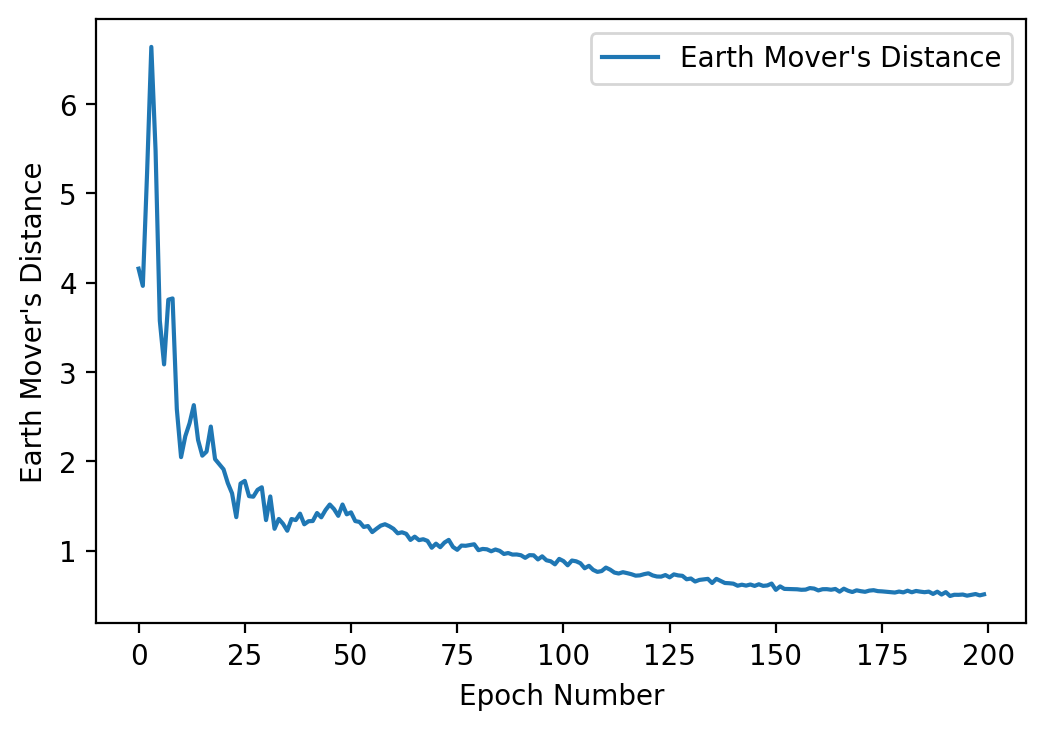

In [13]:
# Plot Earth Mover's Distance
plt.plot([i for i in range(opt.n_epochs)], per_epoch_emd, label='Earth Mover\'s Distance')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Earth Mover\'s Distance")

# Show the plot
plt.show()

# Variational Autoencoder (VAE)

In [ ]:
# Code cell for preparing the VAE

# Global values for training
latent_dims = 2
epochs = 50

autoencoder = vae.VariationalAutoencoder(latent_dims).to(device) # GPU
print(autoencoder.encoder)
print(autoencoder.decoder)

In [ ]:
# Code cell for training the VAE model

opt = torch.optim.Adam(autoencoder.parameters())
vae_saved_imgs = []
reconstruction_loss = []

for epoch in range(epochs):
    start_time = time()
    running_loss = 0
    for x, y in mnist_train_loader:
        x = x.to(device=device)  # GPU
        opt.zero_grad()
        x_hat = autoencoder(x)
        loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
        running_loss += loss.item()
        loss.backward()
        opt.step()
    end_time = time()
    # Get the time to training
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)

    vae.plot_reconstructed(autoencoder, device)
    break
    # Print the output if the number of epochs is equal to one in this list
    grid = torchvision.utils.make_grid(x_hat.data.cpu(), nrow=10)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    vae_saved_imgs.append(img)

    # Append to the reconstruction loss
    reconstruction_loss.append(running_loss / len(mnist_train_set.data))

    # Print some output from this epoch
    print(f'Epoch: {epoch+1:02} | Epoch time (VAE Training): {epoch_mins}m {epoch_secs}s')
    print(f'\t Mean reconstruction loss: {reconstruction_loss[epoch]:.5f}')

Epoch: 01 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 532.51439
Epoch: 02 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 530.04075
Epoch: 03 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 527.94588
Epoch: 04 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 526.96349
Epoch: 05 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 525.98938
Epoch: 06 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 525.25412
Epoch: 07 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 524.37291
Epoch: 08 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 524.13874
Epoch: 09 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 523.30189
Epoch: 10 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 522.89122
Epoch: 11 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 522.45210
Epoch: 12 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 52

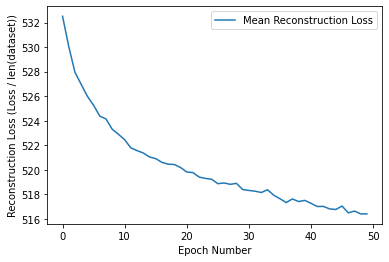

In [ ]:
# Plot images
img_indexes = [0, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (10, 10))
    plt.title(f'Epoch {i+1}')
    plt.imshow(vae_saved_imgs[i], interpolation='nearest')
    plt.savefig(f'D:/temp/Epoch_{i+1}')

In [ ]:
# Plot the reconstruction loss
plt.plot([i for i in range(epochs)], reconstruction_loss, label='Mean Reconstruction Loss')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Reconstruction Loss (Loss / len(dataset))")

# Show the plot
plt.show()
plt.savefig(f'D:/temp/ReconstructionLoss.png')
